# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [ ]:
#we are using cars_hw.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

1. Clean Data and perform EDA and vis to get to know the data set

In [2]:
df = pd.read_csv("cars_hw.csv")
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [3]:
#standadize & make all column names lower case, get rid of space, etc
df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('[^0-9a-zA-Z_]+', '', regex=True)
)
df.columns

Index(['unnamed_0', 'make', 'make_year', 'color', 'body_type', 'mileage_run',
       'no_of_owners', 'seating_capacity', 'fuel_type', 'transmission',
       'transmission_type', 'price'],
      dtype='object')

In [4]:
#clean no_of_owners to be from 1st, 2nd, 3rd to 1,2,3
df['no_of_owners'] = (
    df['no_of_owners']
    .astype(str)
    .str.extract(r'(\d+)')
    .astype(float)
)

In [5]:
#clean up transmission to remove speed from numbers
df['transmission'] = (
    df['transmission']
    .astype(str)
    .str.extract(r'(\d+)')
    .astype(float)
)

In [6]:
#remove white space
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

In [7]:
#check missing values
df.isna()
df.isna().sum()
#seems to be no missing values in the dataset

,0
unnamed_0,0
make,0
make_year,0
color,0
body_type,0
mileage_run,0
no_of_owners,0
seating_capacity,0
fuel_type,0
transmission,3


In [8]:
#remove duplicate values if any
df.duplicated().sum()
#there are no duplicates

np.int64(0)

In [9]:
#change string -> number
num_col = ['make_year', 'price', 'mileage_run', 'seating_capacity', 'no_of_owners','transmission']
for col in num_col:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [10]:
#describe data
print(df.shape)
display(df.describe())

(976, 12)


,unnamed_0,make_year,mileage_run,no_of_owners,seating_capacity,transmission,price
count,976.000000,976.000000,976.000000,976.000000,976.000000,973.000000,9.760000e+02
mean,488.500000,2016.963115,41571.195697,1.165984,5.095287,5.166495,7.410195e+05
std,281.891232,2.818742,24390.995134,0.383119,0.446224,0.502082,3.673234e+05
min,1.000000,2011.000000,1117.000000,1.000000,4.000000,4.000000,1.880000e+05
25%,244.750000,2015.000000,22676.750000,1.000000,5.000000,5.000000,4.757500e+05
50%,488.500000,2017.000000,37570.500000,1.000000,5.000000,5.000000,6.665000e+05
75%,732.250000,2019.000000,57421.250000,1.000000,5.000000,5.000000,8.830000e+05
max,976.000000,2022.000000,99495.000000,3.000000,8.000000,7.000000,2.941000e+06


In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
print("Numeric variables:", list(numeric_cols))
print("Categorical variables:", list(categorical_cols))

Numeric variables: ['unnamed_0', 'make_year', 'mileage_run', 'no_of_owners', 'seating_capacity', 'transmission', 'price']
Categorical variables: ['make', 'color', 'body_type', 'fuel_type', 'transmission_type']


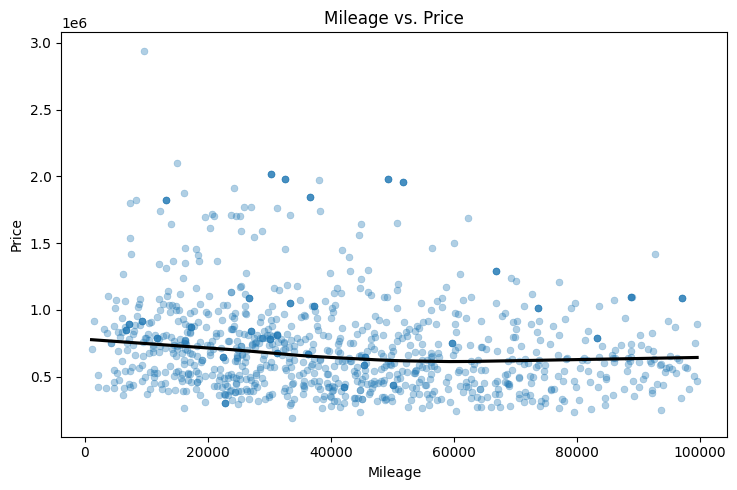

In [12]:
#Mileage vs. Price Graph
plt.figure(figsize=(7.5, 5))
sns.scatterplot(
    data=df, x="mileage_run", y="price",
    alpha=0.35, s=25, edgecolor=None
)
sns.regplot(
    data=df, x="mileage_run", y="price",
    scatter=False, lowess=True, color="black"
)
plt.title("Mileage vs. Price")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2857061104.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["yr_bin", "mil_bin"])["price"]


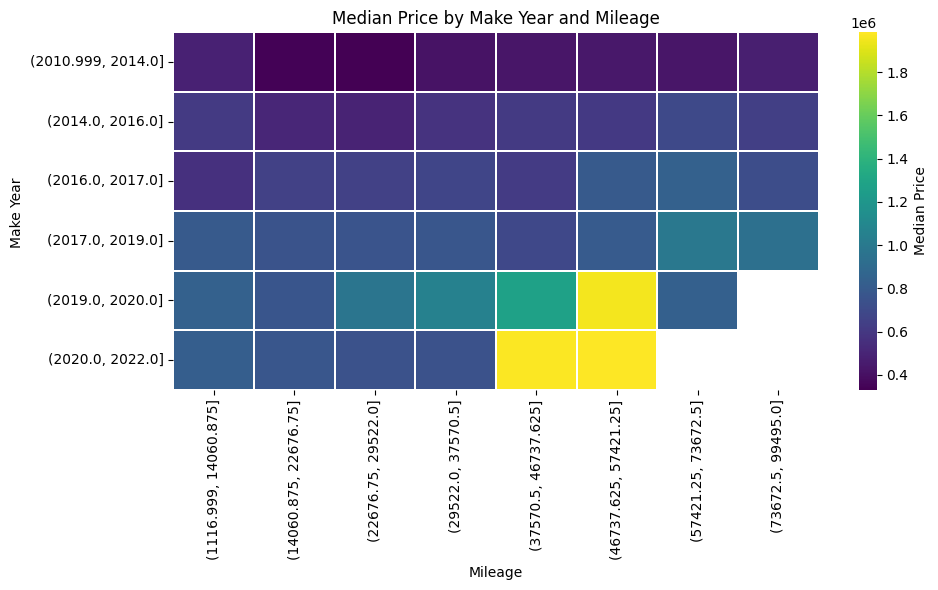

In [13]:
#heat map to observe relationship/interaction betwen make year and mileage on price
mil_bins = pd.qcut(df["mileage_run"], q=8, duplicates="drop")
yr_bins  = pd.qcut(df["make_year"],  q=6, duplicates="drop")

heat = (
    df.assign(mil_bin=mil_bins, yr_bin=yr_bins)
       .groupby(["yr_bin", "mil_bin"])["price"]
       .median()
       .unstack("mil_bin")
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heat, annot=False, cmap="viridis", cbar_kws={"label": "Median Price"},
    linewidths=0.3
)
plt.title("Median Price by Make Year and Mileage")
plt.xlabel("Mileage")
plt.ylabel("Make Year ")
plt.tight_layout()
plt.show()

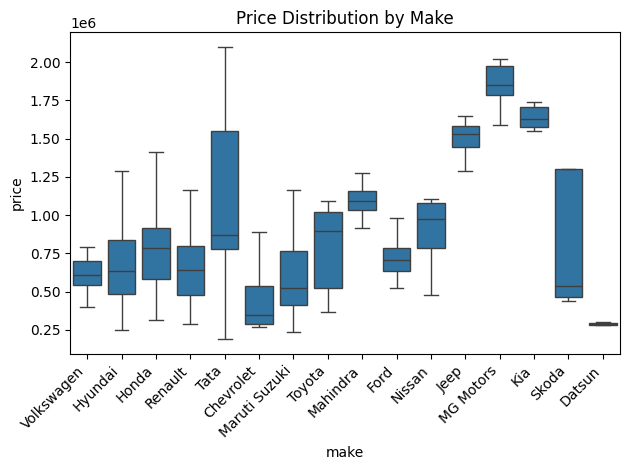

In [14]:
#make vs price
plt.figure()
sns.boxplot(data=df, x="make", y="price", showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("Price Distribution by Make")
plt.tight_layout()
plt.show()

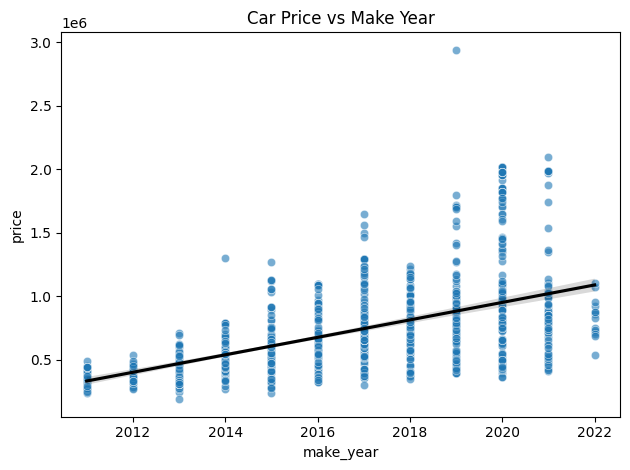

In [15]:
#make year vs price
plt.figure()
sns.scatterplot(data=df, x="make_year", y="price", alpha=0.6)
sns.regplot(data=df, x="make_year", y="price", scatter=False, color="black")
plt.title("Car Price vs Make Year")
plt.tight_layout()
plt.show()

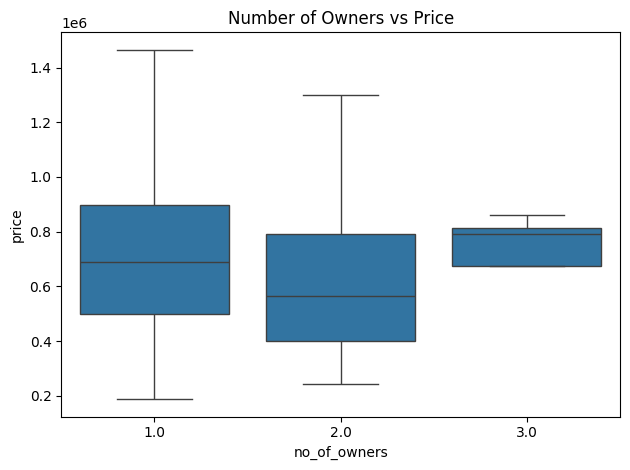

In [16]:
#num of owners vs price
plt.figure()
sns.boxplot(data=df, x="no_of_owners", y="price", showfliers=False)
plt.title("Number of Owners vs Price")
plt.tight_layout()
plt.show()

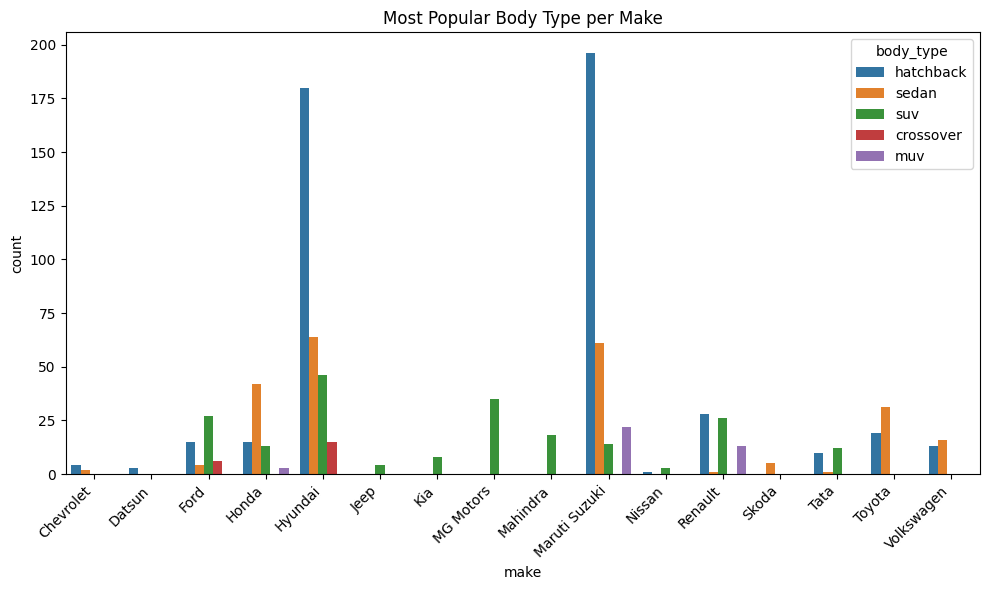

In [17]:
#most popular body type for each make
popular_body = (
    df.groupby(["make", "body_type"])
    .size()
    .reset_index(name="count")
    .sort_values(["make", "count"], ascending=[True, False])
)
plt.figure(figsize=(10,6))
sns.barplot(data=popular_body, x="make", y="count", hue="body_type")
plt.xticks(rotation=45, ha="right")
plt.title("Most Popular Body Type per Make")
plt.tight_layout()
plt.show()

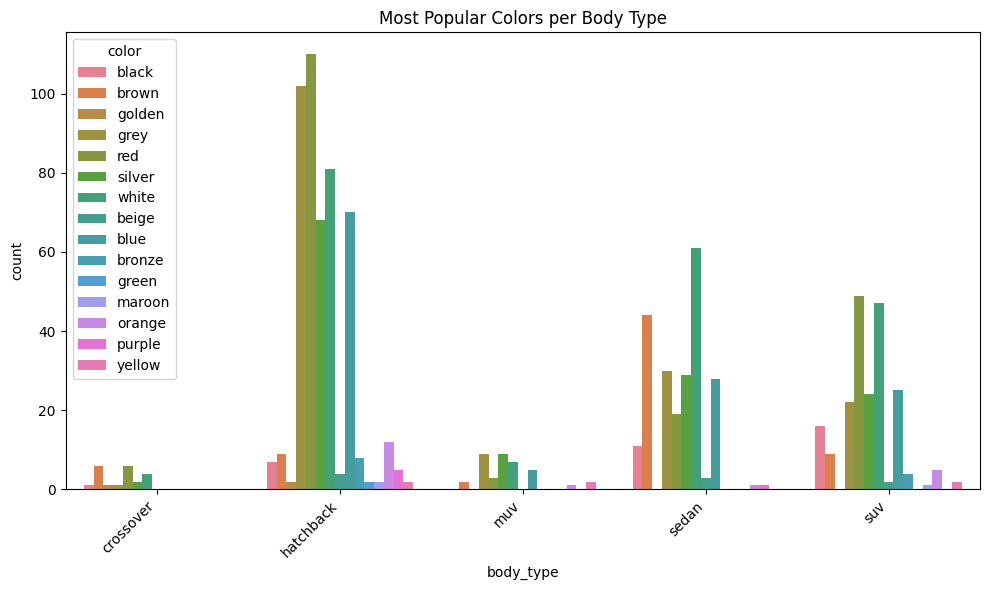

In [18]:
#most popular color within each body
popular_color = (
    df.groupby(["body_type", "color"])
    .size()
    .reset_index(name="count")
)
plt.figure(figsize=(10,6))
sns.barplot(data=popular_color, x="body_type", y="count", hue="color")
plt.xticks(rotation=45, ha="right")
plt.title("Most Popular Colors per Body Type")
plt.tight_layout()
plt.show()

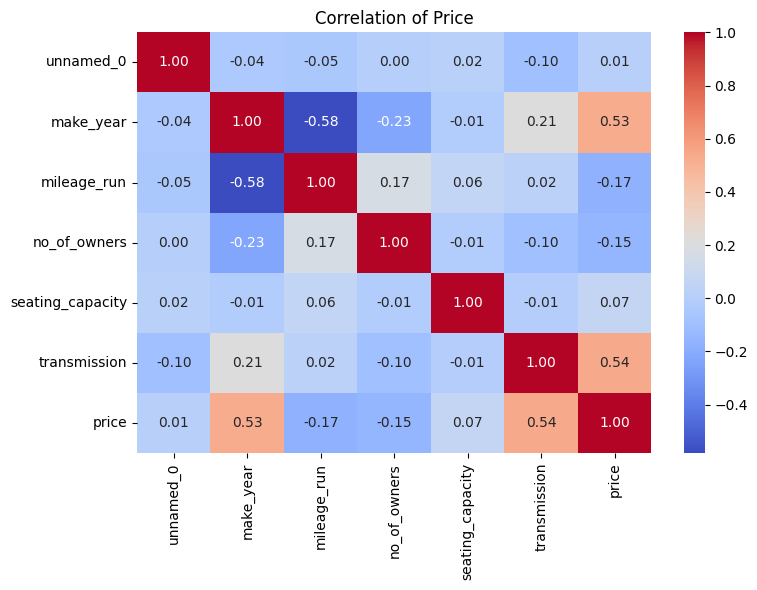

In [19]:
#heatmap to see what is most stronlgy correlated with price
plt.figure(figsize=(8,6))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Price")
plt.tight_layout()
plt.show()

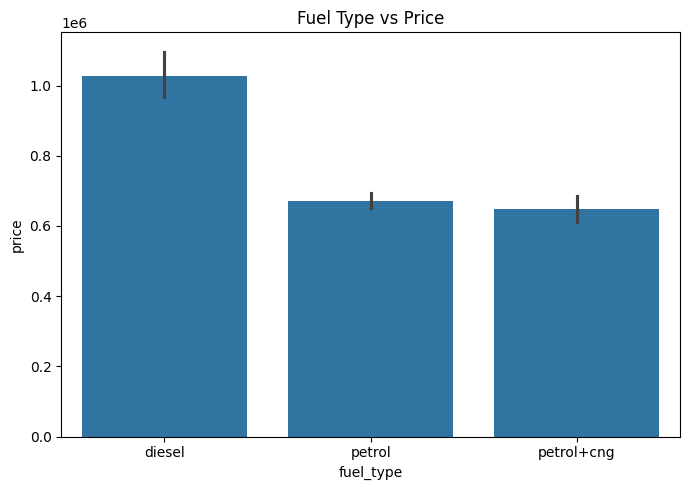

In [20]:
#price vs fuel type
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="fuel_type", y="price", estimator=np.mean)
plt.title("Fuel Type vs Price")
plt.tight_layout()
plt.show()

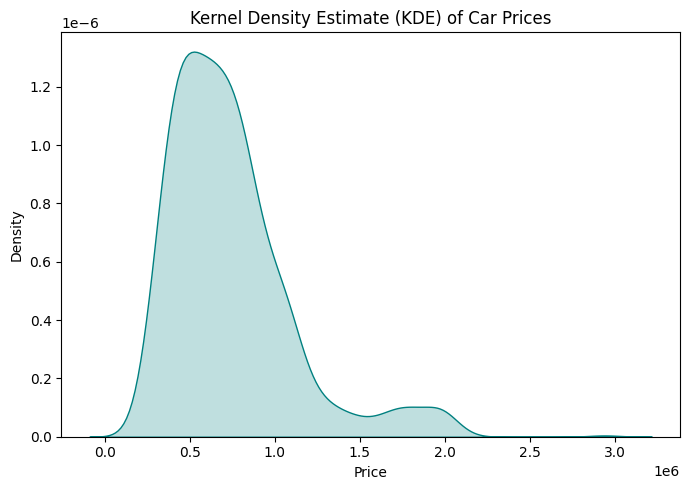

In [21]:
#view distribution of car prices
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="price",
    fill=True,
    color="teal",
    bw_adjust=1
)
plt.title("Kernel Density Estimate (KDE) of Car Prices")
plt.xlabel("Price")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

2. Transform variables, especially categorical, for regression

In [22]:
y = df["price"]
X = df.drop(columns=["price"])

numeric_cols = X.select_dtypes(include=["number"]).columns
categorical_cols = X.select_dtypes(exclude=["number"]).columns

print("Numeric columns:", list(numeric_cols))
print("Categorical columns:", list(categorical_cols))

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(X_encoded.head())


Numeric columns: ['unnamed_0', 'make_year', 'mileage_run', 'no_of_owners', 'seating_capacity', 'transmission']
Categorical columns: ['make', 'color', 'body_type', 'fuel_type', 'transmission_type']
   unnamed_0  make_year  mileage_run  no_of_owners  seating_capacity  \
0          1       2017        44611           1.0                 5   
1          2       2016        20305           1.0                 5   
2          3       2019        29540           2.0                 5   
3          4       2017        35680           1.0                 5   
4          5       2017        25126           1.0                 5   

   transmission  make_Datsun  make_Ford  make_Honda  make_Hyundai  ...  \
0           7.0        False      False       False         False  ...   
1           5.0        False      False       False          True  ...   
2           5.0        False      False        True         False  ...   
3           5.0        False      False       False         False  ...   


3. do 80/20 split. put test data aside

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
)

#check
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Training set shape: (780, 11)
Test set shape: (196, 11)
Training target shape: (780,)
Test target shape: (196,)


4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select only numeric columns for simple models (excluding the unnamed_0 column)
X_train_numeric = X_train.select_dtypes(include=np.number).drop(columns=['unnamed_0'])
X_test_numeric = X_test.select_dtypes(include=np.number).drop(columns=['unnamed_0'])

# Drop rows with NaN values in the numeric features
X_train_numeric = X_train_numeric.dropna()
y_train_numeric = y_train[X_train_numeric.index]

X_test_numeric = X_test_numeric.dropna()
y_test_numeric = y_test[X_test_numeric.index]


# Model 1: Using all numeric features
model_numeric = LinearRegression()
model_numeric.fit(X_train_numeric, y_train_numeric)

y_train_pred_numeric = model_numeric.predict(X_train_numeric)
y_test_pred_numeric = model_numeric.predict(X_test_numeric)

rmse_train_numeric = np.sqrt(mean_squared_error(y_train_numeric, y_train_pred_numeric))
r2_train_numeric = r2_score(y_train_numeric, y_train_pred_numeric)
rmse_test_numeric = np.sqrt(mean_squared_error(y_test_numeric, y_test_pred_numeric))
r2_test_numeric = r2_score(y_test_numeric, y_test_pred_numeric)

print("Model 1 (Numeric Features Only):")
print(f"  Training RMSE: {rmse_train_numeric:.2f}")
print(f"  Training R^2: {r2_train_numeric:.2f}")
print(f"  Test RMSE: {rmse_test_numeric:.2f}")
print(f"  Test R^2: {r2_test_numeric:.2f}")

Model 1 (Numeric Features Only):
  Training RMSE: 269350.67
  Training R^2: 0.48
  Test RMSE: 243365.13
  Test R^2: 0.48


In [25]:
# Model 2: Using a subset of numeric features (e.g., make_year, mileage_run, transmission)
X_train_subset = X_train[['make_year', 'mileage_run', 'transmission']].select_dtypes(include=np.number)
X_test_subset = X_test[['make_year', 'mileage_run', 'transmission']].select_dtypes(include=np.number)

# Drop rows with NaN values that were introduced during cleaning in the selected subset
X_train_subset = X_train_subset.dropna()
y_train_subset = y_train[X_train_subset.index]

X_test_subset = X_test_subset.dropna()
y_test_subset = y_test[X_test_subset.index]

model_subset = LinearRegression()
model_subset.fit(X_train_subset, y_train_subset)

y_train_pred_subset = model_subset.predict(X_train_subset)
y_test_pred_subset = model_subset.predict(X_test_subset)

rmse_train_subset = np.sqrt(mean_squared_error(y_train_subset, y_train_pred_subset))
r2_train_subset = r2_score(y_train_subset, y_train_pred_subset)
rmse_test_subset = np.sqrt(mean_squared_error(y_test_subset, y_test_pred_subset))
r2_test_subset = r2_score(y_test_subset, y_test_pred_subset)

print("\nModel 2 (Subset of Numeric Features):")
print(f"  Training RMSE: {rmse_train_subset:.2f}")
print(f"  Training R^2: {r2_train_subset:.2f}")
print(f"  Test RMSE: {rmse_test_subset:.2f}")
print(f"  Test R^2: {r2_test_subset:.2f}")


Model 2 (Subset of Numeric Features):
  Training RMSE: 271097.90
  Training R^2: 0.47
  Test RMSE: 243221.31
  Test R^2: 0.48


In [28]:
# Model 3: Using one-hot encoded categorical features and all numeric features (excluding unnamed_0)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(
    X_encoded.drop(columns=['unnamed_0']), y,
    test_size=0.2,
    random_state=42,
)

# Drop rows with NaN values in the encoded features
X_train_encoded = X_train_encoded.dropna()
y_train_encoded = y_train_encoded[X_train_encoded.index]

X_test_encoded = X_test_encoded.dropna()
y_test_encoded = y_test_encoded[X_test_encoded.index]

model_encoded = LinearRegression()
model_encoded.fit(X_train_encoded, y_train_encoded)

y_train_pred_encoded = model_encoded.predict(X_train_encoded)
y_test_pred_encoded = model_encoded.predict(X_test_encoded)

rmse_train_encoded = np.sqrt(mean_squared_error(y_train_encoded, y_train_pred_encoded))
r2_train_encoded = r2_score(y_train_encoded, y_train_pred_encoded)
rmse_test_encoded = np.sqrt(mean_squared_error(y_test_encoded, y_test_pred_encoded))
r2_test_encoded = r2_score(y_test_encoded, y_test_pred_encoded)

print("\nModel 3 (All Features including One-Hot Encoded Categorical):")
print(f"  Training RMSE: {rmse_train_encoded:.2f}")
print(f"  Training R^2: {r2_train_encoded:.2f}")
print(f"  Test RMSE: {rmse_test_encoded:.2f}")
print(f"  Test R^2: {r2_test_encoded:.2f}")


Model 3 (All Features including One-Hot Encoded Categorical):
  Training RMSE: 143486.24
  Training R^2: 0.85
  Test RMSE: 144921.04
  Test R^2: 0.82


Model 3 has the lowest RMSE and the highest R². This indicates that it makes more accurate predictions and explains a larger proportion of the variance in the car prices compared to Model 1 and Model 2. Therefore, Model 3 performed the best among the simple linear models.



5. Make partial correlation plots for each of the numeric variables in the model.



Partial Regression Plots:


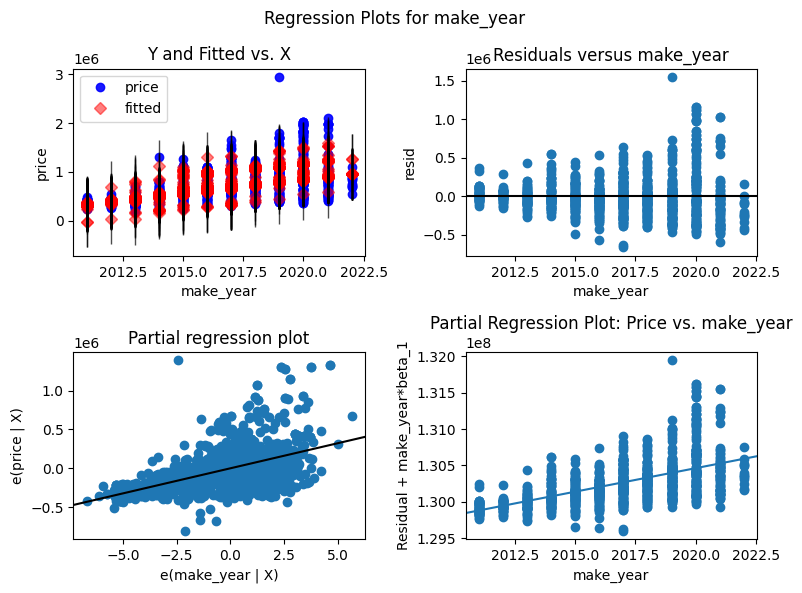

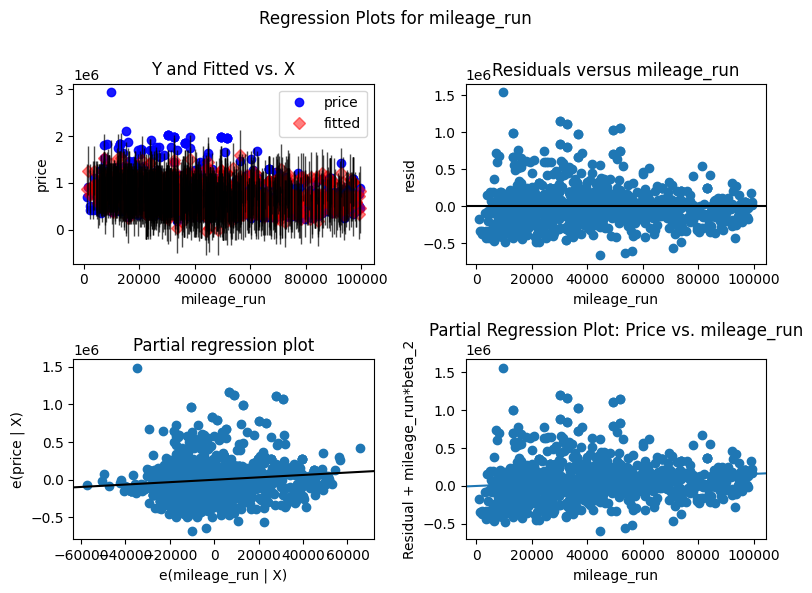

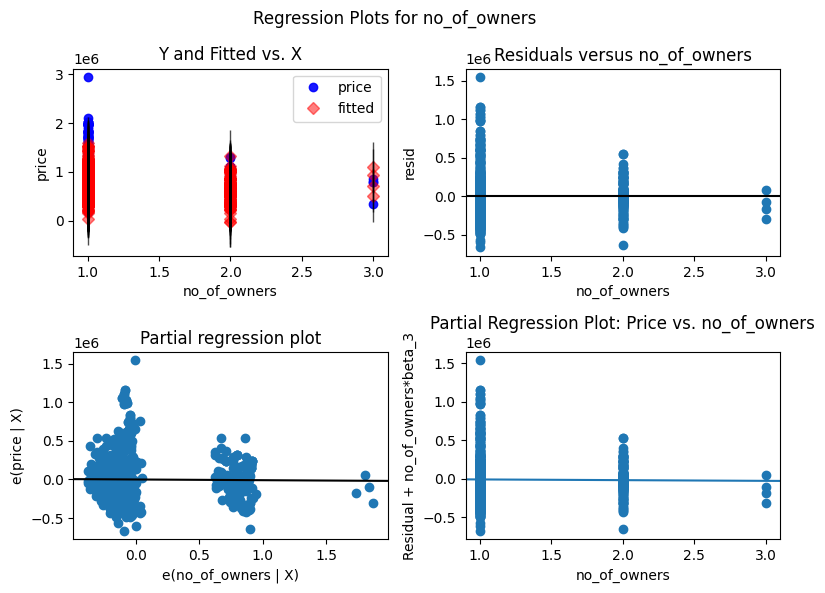

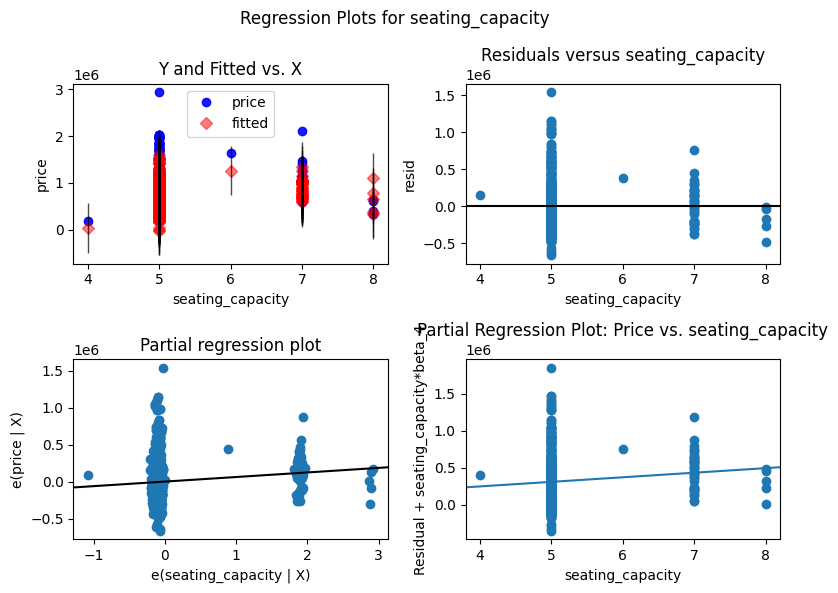

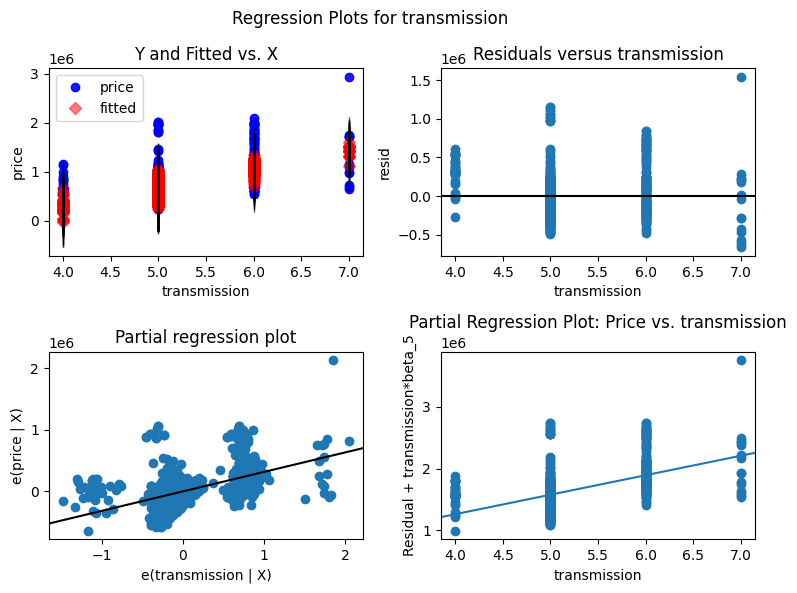

In [32]:
# We'll use the encoded data for this step, focusing on the original numeric columns
numeric_cols_for_partial_corr = ['make_year', 'mileage_run', 'no_of_owners', 'seating_capacity', 'transmission']
X_numeric_for_partial_corr = X_encoded[numeric_cols_for_partial_corr]

# Drop rows with NaN values in the selected numeric features and corresponding target values
X_numeric_for_partial_corr = X_numeric_for_partial_corr.dropna()
y_for_partial_corr = y[X_numeric_for_partial_corr.index]

# Add a constant term for the statsmodels model
X_numeric_for_partial_corr = sm.add_constant(X_numeric_for_partial_corr)

# Fit a linear regression model using statsmodels
model_sm = sm.OLS(y_for_partial_corr, X_numeric_for_partial_corr).fit()

# Plot partial correlation plots for each numeric variable against price
print("\nPartial Regression Plots:")
for col in numeric_cols_for_partial_corr:
    if col in model_sm.model.exog_names:
        fig = sm.graphics.plot_regress_exog(
            model_sm,
            col,
            fig=plt.figure(figsize=(8, 6))
        )
        plt.title(f"Partial Regression Plot: Price vs. {col}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping partial regression plot for {col} as it's not in the statsmodels model.")

There are no significant or obvious non-linearities clearly visible in any of the partial regression plots for the numeric variables. The relationships appear to be mostly linear, or too scattered to see a clear non-linear pattern.